In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!cp -r /content/drive/MyDrive/rafdb /content/rafdb

In [3]:
TRAIN_DIR = "/content/drive/MyDrive/rafdb/train"
TEST_DIR  = "/content/drive/MyDrive/rafdb/test"

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

from sklearn.metrics import classification_report, confusion_matrix

In [5]:
import tensorflow as tf
train_data = tf.keras.utils.image_dataset_from_directory(
    TRAIN_DIR,
    image_size=(224,224),
    batch_size=64,
    label_mode="categorical",
    shuffle=True
)

test_data = tf.keras.utils.image_dataset_from_directory(
    TEST_DIR,
    image_size=(224,224),
    batch_size=64,
    label_mode="categorical",
    shuffle=False
)

class_names = train_data.class_names
NUM_CLASSES = len(class_names)
class_names


AUTOTUNE = tf.data.AUTOTUNE
train_data = train_data.prefetch(tf.data.AUTOTUNE)
test_data  = test_data.prefetch(tf.data.AUTOTUNE)

Found 11275 files belonging to 5 classes.
Found 2835 files belonging to 5 classes.


In [6]:
from sklearn.utils.class_weight import compute_class_weight

# Extract all labels from tf.data.Dataset
y_train = np.concatenate([
    np.argmax(y.numpy(), axis=1)
    for _, y in train_data
])

class_weights = compute_class_weight(
    class_weight="balanced",
    classes=np.unique(y_train),
    y=y_train
)

class_weights = dict(enumerate(class_weights))
class_weights

{0: np.float64(3.1895332390381896),
 1: np.float64(0.4725481978206203),
 2: np.float64(0.8934231378763867),
 3: np.float64(1.1377396569122098),
 4: np.float64(1.748062015503876)}

In [7]:
class_names = ['Angry', 'Happy', 'Neutral', 'Sad', 'Surprise']

In [8]:
from tensorflow.keras.applications.vgg19 import preprocess_input

train_data_vgg = train_data.map(lambda x, y: (preprocess_input(x), y))
test_data_vgg  = test_data.map(lambda x, y: (preprocess_input(x), y))

In [9]:
base_model = tf.keras.applications.VGG19(
    weights="imagenet",
    include_top=False,
    input_shape=(224,224,3)
)

base_model.trainable = False

x = base_model.output
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Dense(256, activation="relu")(x)
x = tf.keras.layers.Dropout(0.6)(x)

outputs = tf.keras.layers.Dense(NUM_CLASSES, activation="softmax")(x)

model = tf.keras.Model(inputs=base_model.input, outputs=outputs)

80134624/80134624 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [10]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-4),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

In [11]:
history_head = model.fit(
    train_data_vgg,
    validation_data=test_data_vgg,
    epochs=10,
    class_weight=class_weights
)

Epoch 1/10
177/177 ━━━━━━━━━━━━━━━━━━━━ 119s 528ms/step - accuracy: 0.2505 - loss: 2.3939 - val_accuracy: 0.3485 - val_loss: 1.6111
Epoch 2/10
177/177 ━━━━━━━━━━━━━━━━━━━━ 83s 465ms/step - accuracy: 0.3157 - loss: 1.9615 - val_accuracy: 0.4399 - val_loss: 1.4421
Epoch 3/10
177/177 ━━━━━━━━━━━━━━━━━━━━ 79s 443ms/step - accuracy: 0.3655 - loss: 1.7378 - val_accuracy: 0.4899 - val_loss: 1.3471
Epoch 4/10
177/177 ━━━━━━━━━━━━━━━━━━━━ 78s 439ms/step - accuracy: 0.3978 - loss: 1.6212 - val_accuracy: 0.5101 - val_loss: 1.2979
Epoch 5/10
177/177 ━━━━━━━━━━━━━━━━━━━━ 78s 441ms/step - accuracy: 0.4197 - loss: 1.5297 - val_accuracy: 0.5273 - val_loss: 1.2376
Epoch 6/10
177/177 ━━━━━━━━━━━━━━━━━━━━ 78s 441ms/step - accuracy: 0.4441 - loss: 1.4596 - val_accuracy: 0.5379 - val_loss: 1.2091
Epoch 7/10
177/177 ━━━━━━━━━━━━━━━━━━━━ 78s 440ms/step - accuracy: 0.4697 - loss: 1.3718 - val_accuracy: 0.5534 - val_loss: 1.1833
Epoch 8/10
177/177 ━━━━━━━━━━━━━━━━━━━━ 87s 467ms/step - accuracy: 0.4850 - loss: 

In [13]:
for layer in base_model.layers[-15:]:
    layer.trainable = True

model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-5),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

callbacks = [
    tf.keras.callbacks.EarlyStopping(
        monitor="val_loss",
        patience=4,
        restore_best_weights=True
    ),
    tf.keras.callbacks.ModelCheckpoint(
        "/content/drive/MyDrive/vgg19_best.keras",
        monitor="val_loss",
        save_best_only=True
    )
]

history_fine = model.fit(
    train_data_vgg,
    validation_data=test_data_vgg,
    epochs=20,
    class_weight=class_weights,
    callbacks=callbacks
)

Epoch 1/20
177/177 ━━━━━━━━━━━━━━━━━━━━ 186s 895ms/step - accuracy: 0.6690 - loss: 0.8196 - val_accuracy: 0.7220 - val_loss: 0.7159
Epoch 2/20
177/177 ━━━━━━━━━━━━━━━━━━━━ 155s 868ms/step - accuracy: 0.7232 - loss: 0.6824 - val_accuracy: 0.7496 - val_loss: 0.6739
Epoch 3/20
177/177 ━━━━━━━━━━━━━━━━━━━━ 196s 841ms/step - accuracy: 0.7657 - loss: 0.5671 - val_accuracy: 0.7810 - val_loss: 0.5831
Epoch 4/20
177/177 ━━━━━━━━━━━━━━━━━━━━ 151s 849ms/step - accuracy: 0.7900 - loss: 0.4850 - val_accuracy: 0.7834 - val_loss: 0.5844
Epoch 5/20
177/177 ━━━━━━━━━━━━━━━━━━━━ 150s 849ms/step - accuracy: 0.8181 - loss: 0.4242 - val_accuracy: 0.7880 - val_loss: 0.5716
Epoch 6/20
177/177 ━━━━━━━━━━━━━━━━━━━━ 153s 862ms/step - accuracy: 0.8484 - loss: 0.3534 - val_accuracy: 0.8032 - val_loss: 0.5201
Epoch 7/20
177/177 ━━━━━━━━━━━━━━━━━━━━ 152s 854ms/step - accuracy: 0.8701 - loss: 0.3231 - val_accuracy: 0.8208 - val_loss: 0.4960
Epoch 8/20
177/177 ━━━━━━━━━━━━━━━━━━━━ 153s 860ms/step - accuracy: 0.8897 -

In [14]:
from tensorflow.keras.models import load_model

model = load_model("/content/drive/MyDrive/vgg19_best.keras")

In [15]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

model = tf.keras.models.load_model("/content/drive/MyDrive/vgg19_best.keras")

y_true, y_pred = [], []

for x, y in test_data_vgg:
    preds = model.predict(x)
    y_true.extend(np.argmax(y.numpy(), axis=1))
    y_pred.extend(np.argmax(preds, axis=1))

print(classification_report(y_true, y_pred, target_names=class_names))

2/2 ━━━━━━━━━━━━━━━━━━━━ 13s 213ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 223ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━

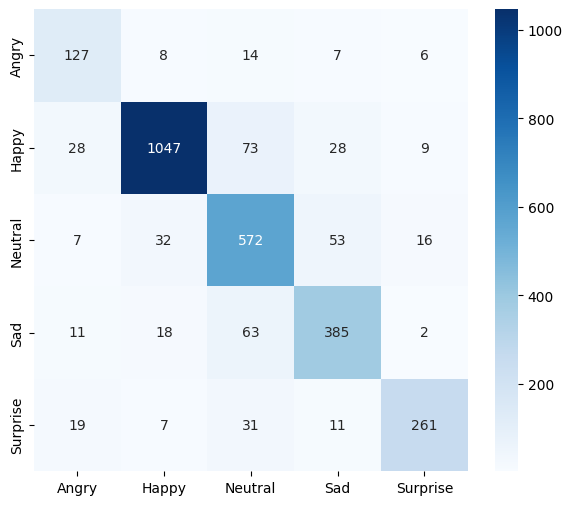

In [16]:
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(7,6))
sns.heatmap(cm, annot=True, fmt="d",
            xticklabels=class_names,
            yticklabels=class_names,
            cmap="Blues")
plt.show()